# Predicción de pérdida de clientes en Empresas de Servicios de Telecomunicaciones (Churn)

Reducir las salidas y [deserciones de clientes](https://www.bain.com/insights/breaking-the-back-of-customer-churn/) se ha convertido en una alta prioridad para la mayoría de los proveedores de servicios de comunicaciones a medida que los mercados maduran y la competencia se intensifica.




En este documento usaremos una base de datos de una empresa de telecomunicaciones anónima [disponibilizada por IBM](https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv). 

El principal objetivo es crear un model de aprendizaje automático basado en SVM y Regresión Logística (Logistic Regression, LR) para predecir la pérdida o salida de clientes en una empresa de telecomunicaciones.


## Librerías

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


## Base de datos

Este conjunto de datos contiene un total de 7043 clientes y 21 características de los mismos. De las entradas, 5174 son clientes activos y 1869 son clientes que la empresa ha perdido. Observe que el conjunto de datos está desbalanceado pues por cada cliente perdido existe casi 3 clientes activos. La variable de salida para nuestro modelo de machine learning será `Churn`.

In [2]:
# importamos dataset
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# vemos las primeras 5 filas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### *Detalles de la base de datos*

*	`customerID` - Custumer unique identifier
*	`gender` - Customer gender - ['Female' 'Male']
*	`SeniorCitizen` - Elderly or retired person, a senior citizen is someone who has at least attained the age of 60 of 65 years
*	`Partner` - - ['No' 'Yes']
*	`Dependents` - If customer has dependents - ['No' 'Yes']
*	`Tenure` - Customer lifespan (in months)
*	`PhoneService` - - ['No' 'Yes']
*	`MultipleLines` - - ['No' 'No phone service' 'Yes']
*	`InternetService` - - ['No' 'No internet service' 'Yes']
*	`OnlineSecurity` - - ['No' 'No internet service' 'Yes']
*	`OnlineBackup` - - ['No' 'No internet service' 'Yes']
*	`DeviceProtection` - - ['No' 'No internet service' 'Yes']
*	`TechSupport` - - ['No' 'No internet service' 'Yes']
*	`StreamingTV` - - ['No' 'No internet service' 'Yes']
*	`StreamingMovies` -  - ['No' 'No internet service' 'Yes']
*	`Contract` - Type of contract - ['Month-to-month' 'One year' 'Two year']
*	`PaperlessBilling` - - ['No' 'Yes']
*	`PaymentMethod` - payment method - ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
*	`MonthlyCharges` - Monthly Recurring Charges
*	`TotalCharges` - Life time value
*	`Churn` - Churn value, the targer vector - ['No' 'Yes']





### *Limpieza del Dataset*

La función get_df_size se utiliza para obtener información básica sobre el tamaño del conjunto de datos, en términos de su número de atributos y entradas.

Luego, se reemplazan los valores en blanco por NaN (valores faltantes) en el dataframe utilizando la función replace de pandas. Se reemplazan los valores faltantes en la columna TotalCharges por la mediana de los valores no faltantes de la misma columna, utilizando la función fillna de pandas. Además, se convierte esta columna de tipo objeto a tipo numérico utilizando la función apply de pandas y el método pd.to_numeric.

A continuación, se elimina la columna customerID, ya que no es una característica relevante para el modelo. Se utiliza el método drop de pandas para eliminar la columna, especificando el argumento axis=1 para indicar que se está eliminando una columna y no una fila.

Por último, se utiliza la función describe de pandas para obtener estadísticas descriptivas del conjunto de datos preprocesado y se imprimen en pantalla la cantidad de instancias con valor "Yes" y "No" en la variable objetivo Churn.

In [3]:
def get_df_size(df, header='Dataset dimensions'):
  print(header,
        '\n# Attributes: ', df.shape[1], 
        '\n# Entries: ', df.shape[0],'\n')
  
get_df_size(df)

#df.info()

# reemplaza valores en blanco por NaN 
df_clean = df.replace(r'^\s*$', np.nan, regex=True)

# reemplaza valores faltantes en TotalCharges por la mediana de TotalCharges.
total_charges_median = df_clean.TotalCharges.median()
df_clean['TotalCharges'].fillna(total_charges_median, inplace=True)
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(pd.to_numeric)

#CustomerID lo retiramos porque no es una característica
df_clean = df_clean.drop('customerID', axis=1)
df_clean.describe()

print("Churn No Instances: ", df_clean[df_clean['Churn'] == 'No'].shape[0])
print("Churn Yes Instances: ", df_clean[df_clean['Churn'] == 'Yes'].shape[0])


Dataset dimensions 
# Attributes:  21 
# Entries:  7043 

Churn No Instances:  5174
Churn Yes Instances:  1869


## Preparación de la Base de Datos








Este código realiza la preprocesamiento de los datos en el dataframe df_clean para poder usarlo en un modelo de machine learning. En primer lugar, identifica las características binarias, numéricas y categóricas en el conjunto de datos. Luego, crea una copia del dataframe original y realiza las siguientes operaciones sobre él:

Convierte las características binarias en etiquetas numéricas mediante el uso de LabelEncoder().
Crea variables dummy para las características categóricas usando pd.get_dummies().
Imprime la información del tamaño del conjunto de datos original y procesado utilizando la función get_df_size().
Retorna un nuevo dataframe df_proc que contiene todas las características preprocesadas y que puede ser utilizado en un modelo de machine learning.
En resumen, el código realiza la limpieza, transformación y preparación de los datos para su posterior uso en un modelo de machine learning.

In [4]:
binary_feat = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
numeric_feat = [col for col in df_clean.select_dtypes(['float','int']).columns.tolist() if col not in binary_feat]
categorical_feat = [ col for col in df_clean.select_dtypes('object').columns.to_list() if col not in binary_feat + numeric_feat ]
df_proc = df_clean.copy()
#Etiquetas para características binarias
le = LabelEncoder()
for i in binary_feat:
  df_proc[i] = le.fit_transform(df_proc[i])
  print(i, '\n', np.unique(df_proc[i].values))
#Dummy variables
df_proc = pd.get_dummies(df_proc, columns=categorical_feat)
get_df_size(df, header='Original dataset:')
get_df_size(df_proc, header='Processed dataset:')
df_proc.head()

gender 
 [0 1]
SeniorCitizen 
 [0 1]
Partner 
 [0 1]
Dependents 
 [0 1]
PhoneService 
 [0 1]
PaperlessBilling 
 [0 1]
Churn 
 [0 1]
Original dataset: 
# Attributes:  21 
# Entries:  7043 

Processed dataset: 
# Attributes:  41 
# Entries:  7043 



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,1,53.85,108.15,1,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,1,70.70,151.65,1,...,True,False,False,True,False,False,False,False,True,False


### *División en conjunto de entrenamiento y test*

In [5]:
# dividimos df_proc en características y salida
X=df_proc.drop('Churn', axis=1)
y=df_proc['Churn']

# Dividimos el conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Actividad 1: Visualización con TSNE 
Utilice TSNE para visualizar su dataset de entrenamiento. Recuerde normalizar su dasaset (zscore) antes de esta y las siguientes actividades. 

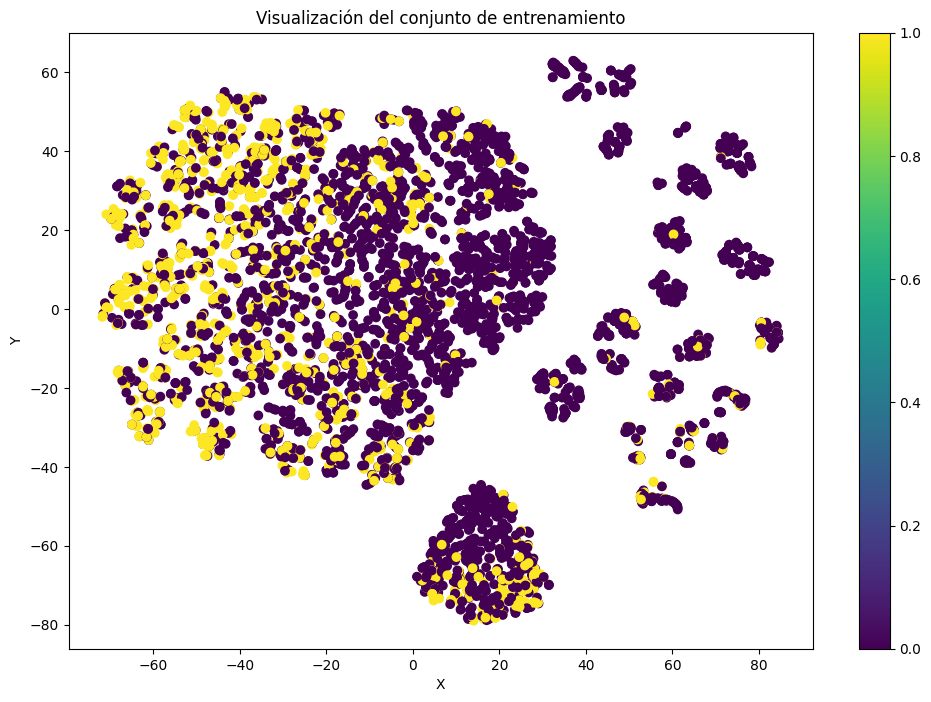

In [6]:
# Z score
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualizamos el conjunto de entrenamiento con TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

# Visualizamos el conjunto de entrenamiento con TSNE
plt.figure(figsize=(12,8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train)
plt.title('Visualización del conjunto de entrenamiento')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()


### Actividad 2: Clasificador y Optimización de Hiperparámetros SVM

Cree un clasificador con SVM (ver `SVC`) con kernel RBF.
Use 5-fold cross-validation (ver `GridSearchCV` y  `StratifiedKFold`) para optimizar los siguientes hiperparámetros en el conjunto de entrenamiento (`X_train`, `y_train`):

1. Gamma 
2. C

Para la optimización de hiperparámetros utilice como métrica al recall.

Una vez optimizados los hiperparámetros, reentrene su clasificador con los mejores hiperparámetros encontrados. Finalmente, evalúe este último clasificador en el conjunto de test ('X_test', 'y_test'.)


In [7]:
# Clasificador SVM, con kernel RBF, 5-fold cross validation para optimizar los hiperparámetros C y gamma
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Definimos los parámetros que queremos optimizar
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

#usa StratifiedKFold para mantener la proporción de clases en cada fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usamos recall como métrica de optimización
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=stratified_kfold, scoring='recall')

# Entrenamos el modelo
grid.fit(X_train, y_train)

# Imprimimos los mejores parámetros
print("The best parameters are %s with a score of %0.2f"
        % (grid.best_params_, grid.best_score_))

# Reentrenamos el modelo con los mejores parámetros
svm = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svm.fit(X_train, y_train)

# Predecimos con el conjunto de test
y_pred = svm.predict(X_test)

# Imprimimos el reporte de clasificación
print(classification_report(y_test, y_pred))



The best parameters are {'C': 100, 'gamma': 0.01} with a score of 0.54
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1035
           1       0.57      0.52      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



### Actividad 3: Clasificador y Optimización de Hiperparámetros Logistic Regression

Repita la actividad 2 pero con Logistic Regression. Bajo el mismo esquema de la actividad anterior, optimice el parámetro de regularización lambda. Utilice una transformación polinomial para garantizar fronteras de decisión no lineal. Compare sus resultados con los obtenidos de la actividad anterior

In [8]:
# Clasificador Logistic Regression, 5-fold cross validation para optimizar el hiperparámetro de regularización lambda, usamos transformacion polinomial
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold


# Definimos los parámetros que queremos optimizar
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],}

# usa StratifiedKFold para mantener la proporción de clases en cada fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usamos recall como métrica de optimización
grid = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=stratified_kfold, scoring='recall')

# Entrenamos el modelo
grid.fit(X_train, y_train)

# Imprimimos los mejores parámetros
print("The best parameters are %s with a score of %0.2f"
        % (grid.best_params_, grid.best_score_))

# Reentrenamos el modelo con los mejores parámetros
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
logreg = LogisticRegression(penalty='l2', C=grid.best_params_['C'])
logreg.fit(X_train_poly, y_train)

# Predecimos con el conjunto de test
y_pred = logreg.predict(X_test_poly)

# Imprimimos el reporte de clasificación
print(classification_report(y_test, y_pred))


The best parameters are {'C': 100} with a score of 0.55
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.78      0.78      0.78      1409



/Users/juancisneros/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EN MI CASO NO HE VISTO UNA MEJORA SIGNIFICATIVA AL USAR UNO U OTRO MODELO, PERO SI SE PUEDE OBSERVAR QUE EL MODELO DE SVM ES MAS ESTABLE EN CUANTO A LA VARIACION DE LOS HIPERPARAMETROS, MIENTRAS QUE EL MODELO DE REGRESION LOGISTICA ES MAS SENSIBLE A LOS CAMBIOS DE LOS HIPERPARAMETROS.